# Initial Setup

Before beginning the assignment, we import the CIFAR dataset, and train a simple convolutional neural network (CNN) to classify it.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
device

device(type='cuda')

Load training and test data from the CIFAR10 dataset.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Define a simple CNN that classifies CIFAR images.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [6]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [7]:
train(net, trainloader)

[1,  2000] loss: 2.215
[1,  4000] loss: 1.840
[1,  6000] loss: 1.685
[1,  8000] loss: 1.596
[1, 10000] loss: 1.565
[1, 12000] loss: 1.501
[2,  2000] loss: 1.457
[2,  4000] loss: 1.414
[2,  6000] loss: 1.387
[2,  8000] loss: 1.370
[2, 10000] loss: 1.346
[2, 12000] loss: 1.341
Finished Training


In [8]:
# print(net)
# print(net.input_activations)

Now that the CNN has been trained, let's test it on our test dataset.

In [9]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 50.06%


In [10]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

# Question 1: Visualize Weights

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# ADD YOUR CODE HERE to plot distributions of weights
import matplotlib.pyplot as plt

# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)

def plot_weights(layer, name):
  fc1_weights = layer.weight.data.cpu().view(-1)
  plt.figure(figsize=(6, 6))
  plt.hist(fc1_weights.numpy(), bins=500, color='blue')
  plt.title(f'Histogram of {name}')
  plt.xlabel('Weight Value')
  plt.ylabel('Frequency')
  plt.show()

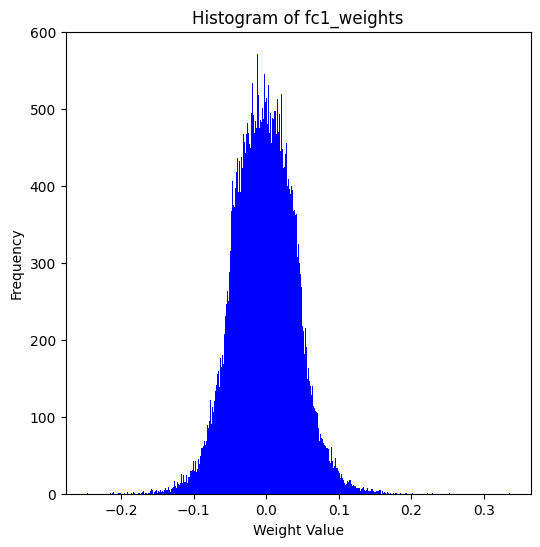

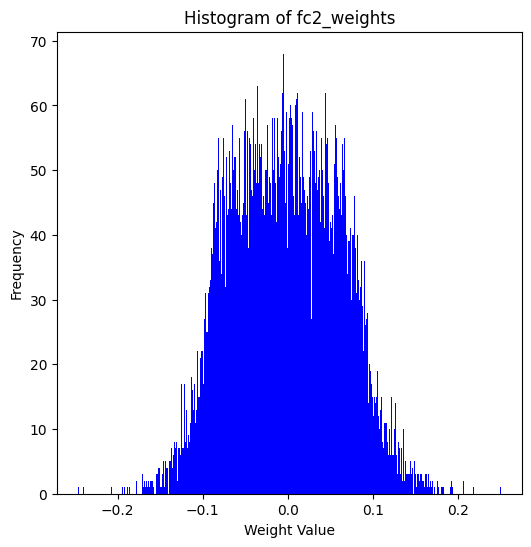

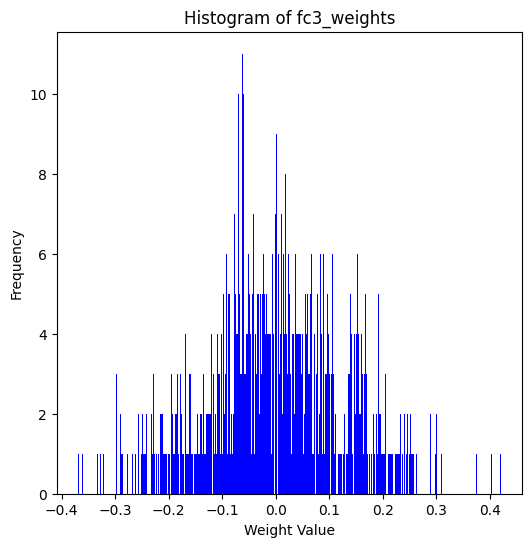

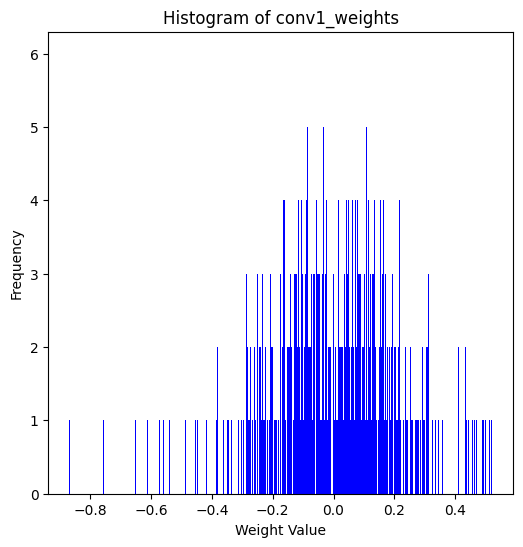

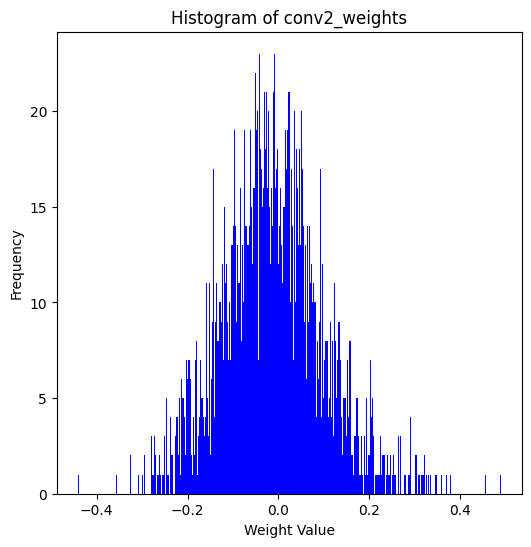

In [13]:
plot_weights(net.fc1, "fc1_weights")
plot_weights(net.fc2, "fc2_weights")
plot_weights(net.fc3, "fc3_weights")
plot_weights(net.conv1, "conv1_weights")
plot_weights(net.conv2, "conv2_weights")

# Question 2: Quantize Weights

In [14]:
net_q2 = copy_model(net)
# print(net_q2.input_activations)

In [15]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    weight_max = torch.max(weights.abs())
    scale = weight_max / 127.0 if weight_max > 0.0 else 1.0

    result = (weights / scale).round()
    return torch.clamp(result, min=-128, max=127), scale

In [16]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [17]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 50.26%


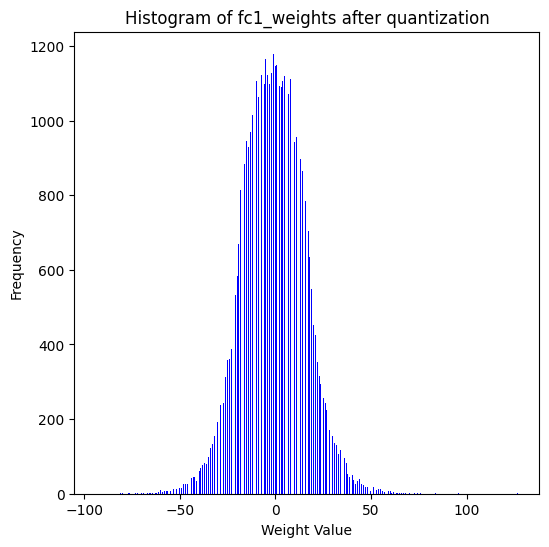

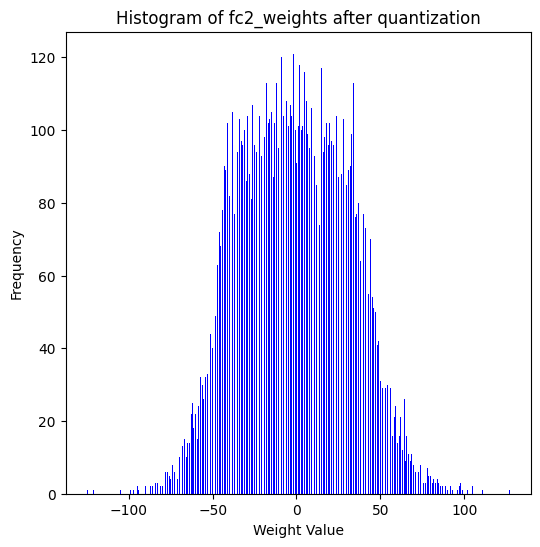

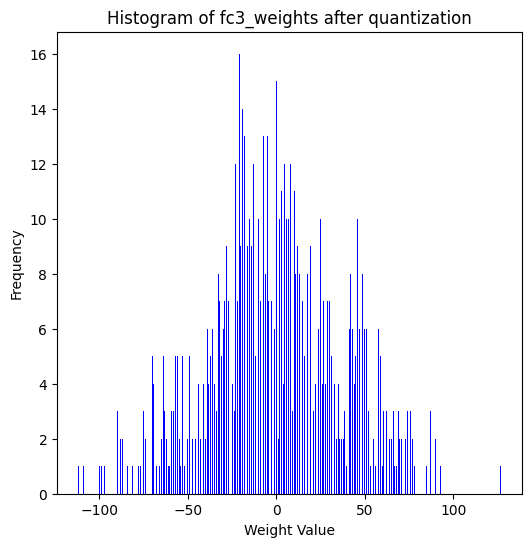

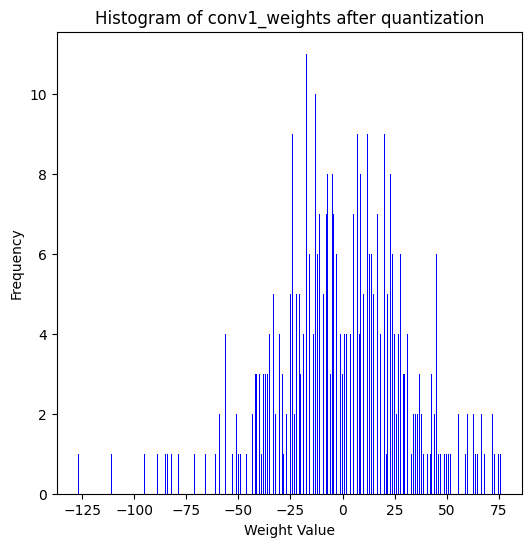

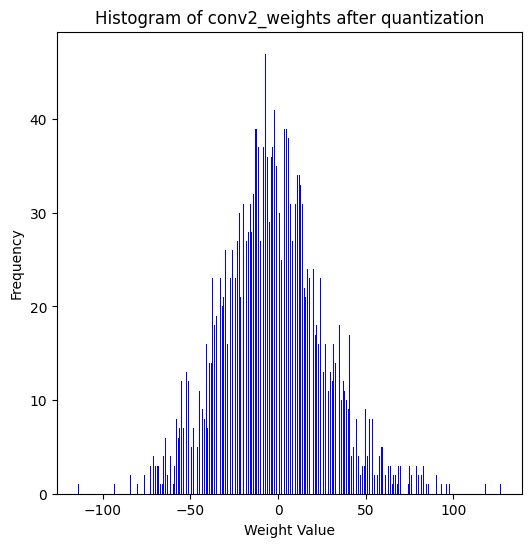

In [18]:
plot_weights(net_q2.fc1, "fc1_weights after quantization")
plot_weights(net_q2.fc2, "fc2_weights after quantization")
plot_weights(net_q2.fc3, "fc3_weights after quantization")
plot_weights(net_q2.conv1, "conv1_weights after quantization")
plot_weights(net_q2.conv2, "conv2_weights after quantization")

# Question 3: Visualize Activations

In [19]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
            # print(f"add input_activations {model.input_activations.shape}")
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [20]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

In [21]:
def plot_histogram_and_get_ranges(activation_tensor, name):
    activation_data = activation_tensor.flatten()

    plt.figure(figsize=(6, 6))
    plt.hist(activation_data, bins=500, color='blue')
    plt.title(f"Histogram of {name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()

    range = np.ptp(activation_data)

    mean = np.mean(activation_data)
    std_dev = np.std(activation_data)
    three_sigma_range = (mean - 3*std_dev, mean + 3*std_dev)

    return range, three_sigma_range

In [22]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

In [23]:
print(net_q3.input_activations.shape)
print(net_q3.conv1.activations.shape)

(1241088,)
(475104,)


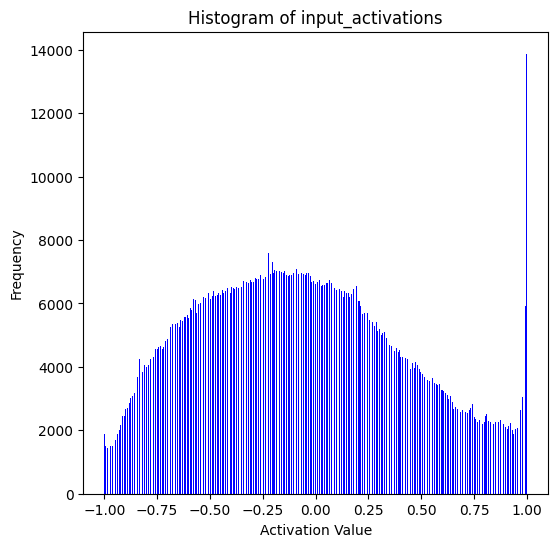

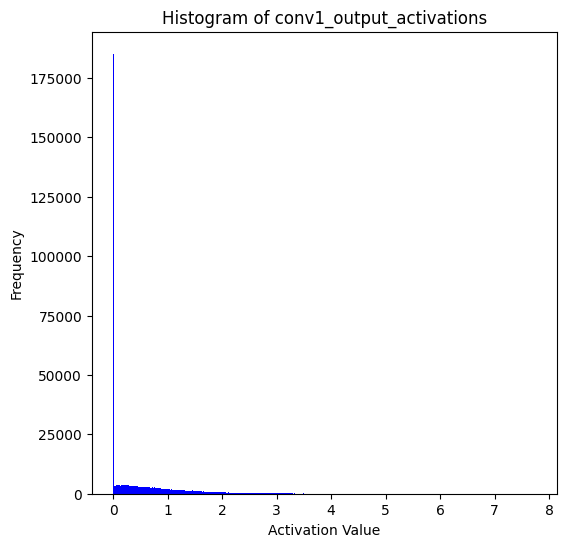

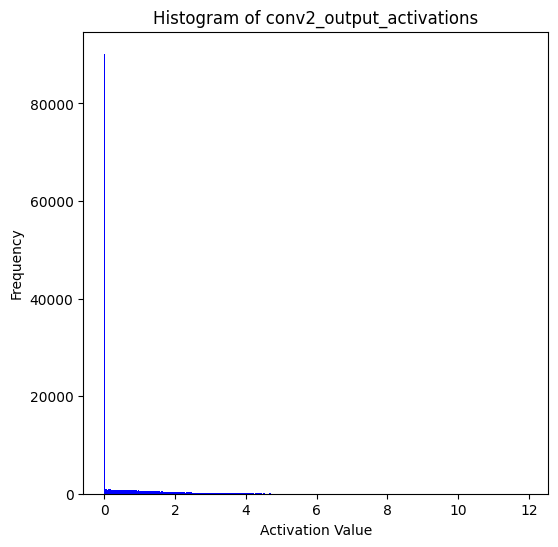

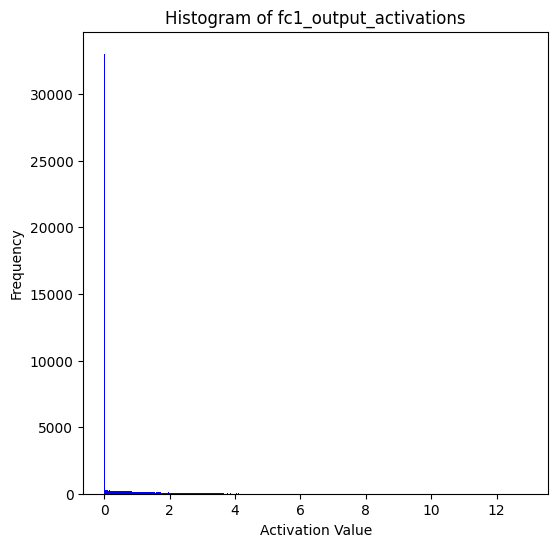

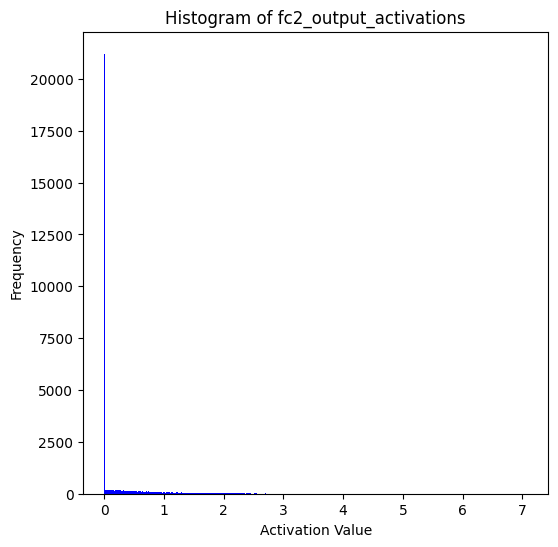

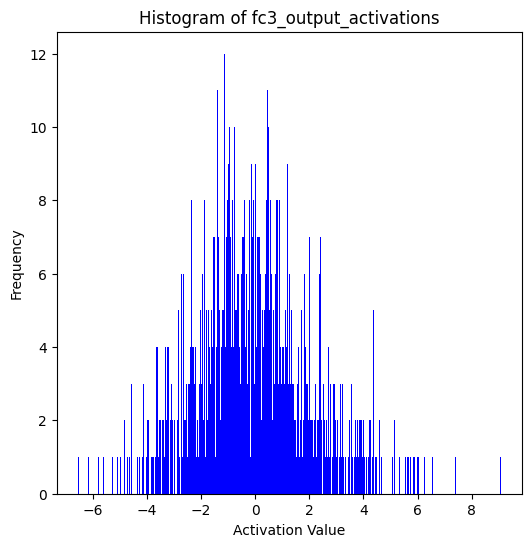

 input_range: 2.0 input_3sigma_range: (np.float64(-1.5467656543027435), np.float64(1.427356480812765))
 conv1_range: 7.756846904754639 conv1_3sigma_range: (np.float64(-1.7497861688571472), np.float64(2.878679561286426))
 fc1_range: 12.929620742797852 fc1_3sigma_range: (np.float64(-2.3410780791395633), np.float64(3.1879404423966924))
 fc2_range: 7.079915523529053 fc2_3sigma_range: (np.float64(-1.556521875468754), np.float64(2.1904435813224645))
 fc3_range: 15.618580341339111 fc3_3sigma_range: (np.float64(-6.486185169518628), np.float64(6.343399254544212))


In [24]:
# ADD YOUR CODE HERE to plot distributions of activations

# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:
input_range, input_3sigma_range = plot_histogram_and_get_ranges(input_activations, "input_activations")
conv1_range, conv1_3sigma_range = plot_histogram_and_get_ranges(conv1_output_activations, "conv1_output_activations")
conv2_range, conv2_3sigma_range = plot_histogram_and_get_ranges(conv2_output_activations, "conv2_output_activations")
fc1_range, fc1_3sigma_range = plot_histogram_and_get_ranges(fc1_output_activations, "fc1_output_activations")
fc2_range, fc2_3sigma_range = plot_histogram_and_get_ranges(fc2_output_activations, "fc2_output_activations")
fc3_range, fc3_3sigma_range = plot_histogram_and_get_ranges(fc3_output_activations, "fc3_output_activations")

for name in ["input", "conv1", "fc1", "fc2", "fc3"]:
  v_name1 = name + "_range"
  v_name2 = name + "_3sigma_range"
  print(f" {v_name1}: {locals()[v_name1]} {v_name2}: {locals()[v_name2]}")

# Question 4: Quantize Activations

In [25]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        # print(f"input_activations {self.input_activations.shape}")
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        max_pixel_value = np.max(pixels)
        scale = max_pixel_value / 127.0 if max_pixel_value > 0 else 1.0

        return scale

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:

        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        # pre_scaling_factor = 1.0
        # if len(ns) == 0:
        #   pre_scaling_factor = n_w * n_initial_input
        # else:
        #   pre_scaling_factor = n_w * ns[-1][1]

        # max_activation_value = np.max(np.abs(activations)) * pre_scaling_factor
        # scaling_factor = 127.0 / max_activation_value if max_activation_value > 0 else 1.0

        scale = n_initial_input

        for weight_scale, output_scale in ns:
          scale = scale * weight_scale / output_scale

        scale *= n_w
        max_activation_value = np.max(np.abs(activations))
        act_scale = max_activation_value / 127.0 if max_activation_value > 0 else 1.0

        return scale / act_scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp

        # ADD YOUR CODE HERE
        x = (x / self.input_scale).round().clamp(-128, 127)

        x = self.conv1(x)
        x = (x * self.conv1.output_scale).round().clamp(-128, 127)

        x = self.pool(F.relu(x))

        x = self.conv2(x)
        x = (x * self.conv2.output_scale).round().clamp(-128, 127)

        x = self.pool(F.relu(x))

        x = x.view(-1, 16 * 5 * 5)

        x = self.fc1(x)
        x = (x * self.fc1.output_scale).round().clamp(-128, 127)

        x = F.relu(x)

        x = self.fc2(x)
        x = (x * self.fc2.output_scale).round().clamp(-128, 127)

        x = F.relu(x)

        x = self.fc3(x)
        x = (x * self.fc3.output_scale).round().clamp(-128, 127)

        return x

In [26]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [27]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 50.2%


# Question 5: Quantize Biases

In [28]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

In [29]:
train(net_with_bias, trainloader)

[1,  2000] loss: 2.255
[1,  4000] loss: 1.881
[1,  6000] loss: 1.724
[1,  8000] loss: 1.624
[1, 10000] loss: 1.572
[1, 12000] loss: 1.509
[2,  2000] loss: 1.450
[2,  4000] loss: 1.405
[2,  6000] loss: 1.413
[2,  8000] loss: 1.394
[2, 10000] loss: 1.362
[2, 12000] loss: 1.321
Finished Training


In [36]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 50.44%


In [45]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [46]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 46.58%


In [67]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)

        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )

        if (self.fc3.bias.data < -2147483648).any() or (self.fc3.bias.data > 2147483647).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''
        scale = n_initial_input
        for weight_scale, output_scale in ns:
            scale *= weight_scale / output_scale

        scale *= n_w

        return (bias / scale).round().clamp(min=-2147483648, max=2147483647)

In [68]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [69]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 50.43%
